In [2]:
import os
import glob
from astropy.io import fits
import pandas as pd
import re

# Path to your directory containing FITS files
directory = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/'

# Find all files in the directory
file_paths = glob.glob(os.path.join(directory, '*'))

# Sort naturally by number in filename
def extract_number(filename):
    match = re.search(r'(\d+)', os.path.basename(filename))
    return int(match.group(1)) if match else float('inf')

file_paths = sorted(file_paths, key=extract_number)

# List to hold results
data_list = []

for file_path in file_paths:
    try:
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            filename = os.path.basename(file_path)
            object_name = header.get('OBJECT', 'UNKNOWN')
            exptime = header.get('EXPTIME', 'N/A')

            # Extract standard COMMENT field
            comment_lines = header.get('COMMENT', [])
            comment = None
            if isinstance(comment_lines, list):
                comment = next((line for line in comment_lines if line.strip()), None)
            elif isinstance(comment_lines, str):
                comment = comment_lines.strip()

            if not comment:
                for alt_key in ['COMMENTX', 'COMENTX', 'COMNT', 'COMMNT']:
                    if alt_key in header:
                        comment = header[alt_key]
                        break

            if not comment:
                comment = 'N/A'

            # Add all fields in desired order
            data_list.append({
                'File Name': filename,
                'Object Name': object_name,
                'Exposure Time (s)': exptime,
                'Comment': comment  # This will appear *after* Exposure Time in the DataFrame
            })

    except Exception as e:
        print(f"Could not read {file_path}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data_list)

# Ensure column order is exactly as requested
df = df[['File Name', 'Object Name', 'Exposure Time (s)', 'Comment']]

# Display full DataFrame
pd.set_option('display.width', 200)  # or any value > total character width of a row
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Print DataFrame
print(df)

# Optional: Save to CSV
# output_csv_path = os.path.join(directory, 'fits_summary_with_exptime_and_comment.csv')
# df.to_csv(output_csv_path, index=False)


Could not read /home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned: [Errno 21] Is a directory: '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned'
        File Name                  Object Name  Exposure Time (s)                Comment
0   aie07018.fits                       AD Leo              300.0                    N/A
1   aie07019.fits                       AD Leo              300.0                    N/A
2   aie07020.fits                       AD Leo              300.0                    N/A
3   aie07021.fits                       AD Leo              300.0  Gr8/167l 300s 15:12ut
4   aie07022.fits                       AD Leo              300.0  Gr8/167l 300s 15:12ut
5   aie07023.fits                       AD Leo              300.0  Gr8/167l 300s 15:12ut
6   aie07024.fits                       AD Leo              300.0  Gr8/167l 300s 15:12ut
7   aie07025.fits                       AD Leo              300.0  Gr

In [8]:
import os
from astropy.io import fits
import numpy as np
import astroscrappy

input_dir = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/'
output_dir = os.path.join(input_dir, 'cosmic_cleaned')
os.makedirs(output_dir, exist_ok=True)

# === HCT Hanle telescope conservative defaults ===
gain = 1.22          
readnoise = 4.8      
sigclip = 6.0        # More conservative than default (4.5)
sigfrac = 0.1        # Only strong cosmic rays are kept
objlim = 7.0         # Needs to be well above the object
satlevel = 65536     # 16-bit CCD

# Counter to track processed files
processed = 0

for filename in os.listdir(input_dir):
    file_path = os.path.join(input_dir, filename)
    if not filename.lower().endswith('.fits') or not os.path.isfile(file_path):
        continue

    with fits.open(file_path) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header

    if data is None or data.ndim < 2 or np.isnan(data).all():
        print(f" Skipping invalid or empty file: {filename}")
        continue

    crmask, clean_data = astroscrappy.detect_cosmics(
        data,
        sigclip=sigclip,
        sigfrac=sigfrac,
        objlim=objlim,
        gain=gain,
        readnoise=readnoise,
        satlevel=satlevel,
        verbose=False
    )

    header['COSMCREM'] = (1, 'Cosmic ray removal applied')
    header.add_history('Cosmic rays removed using L.A.Cosmic (van Dokkum 2001)')

    output_path = os.path.join(output_dir, filename)
    fits.writeto(output_path, clean_data, header=header, overwrite=True, output_verify='silentfix')

    # Optional: save cosmic ray mask
    # mask_path = os.path.join(output_dir, filename.replace('.fits', '_crmask.fits'))
    # fits.writeto(mask_path, crmask.astype(np.uint8), header=header, overwrite=True)

    #print(f" Processed and saved: {filename}")
    #processed += 1

#print(f"\n All cosmic rays cleaned and saved for {processed} FITS file(s).")


In [14]:
from astropy.io import fits
import numpy as np
import os
import pandas as pd
# === Folder and file paths ===
folder_path = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned'
bias_path = os.path.join(folder_path, 'm_bias.fits')

# === Load bias data ===
with fits.open(bias_path) as bias_hdul:
    bias_data = bias_hdul[0].data.astype(float)

# === Output folder ===
output_folder = os.path.join(folder_path, 'bias_subtracted')
os.makedirs(output_folder, exist_ok=True)

# === Process each file ===
for file_name in os.listdir(folder_path):
    if file_name.endswith('.fits') and file_name != 'm_bias.fits':
        file_path = os.path.join(folder_path, file_name)

        with fits.open(file_path) as hdul:
            data = hdul[0].data.astype(float)
            header = hdul[0].header

        # Subtract bias
        corrected_data = data - bias_data

        # Clean header (optional: remove problematic keys)
        for key in ['NAXIS3', 'TIME-OBS', 'TIME-END', 'OBSCODE']:
            if key in header:
                del header[key]

        # Add simple note
        header['BIASSUB'] = True
        header.add_history(f"Bias subtracted for: {file_name}")

        # Save new file
        output_path = os.path.join(output_folder, file_name)
        fits.writeto(output_path, corrected_data, header=header, overwrite=True)
        #print(f"Saved: {output_path}")


In [1]:
from astropy.io import fits
import numpy as np
import os

# === Paths ===
bias_sub_path = '/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/'
flat_fielded_path = os.path.join(bias_sub_path, 'flat_fielded')
os.makedirs(flat_fielded_path, exist_ok=True)

# === Load master halogen flats ===
mflat7_path = os.path.join(bias_sub_path, 'm_halogengr7.fits')
mflat8_path = os.path.join(bias_sub_path, 'm_halogengr8.fits')

mflat7 = fits.getdata(mflat7_path).astype(float)
mflat8 = fits.getdata(mflat8_path).astype(float)

# === Normalize both ===
norm_flat7 = mflat7 / np.median(mflat7)
norm_flat8 = mflat8 / np.median(mflat8)

# === Avoid NaNs / 0s ===
norm_flat7 = np.where((norm_flat7 == 0) | ~np.isfinite(norm_flat7), 1, norm_flat7)
norm_flat8 = np.where((norm_flat8 == 0) | ~np.isfinite(norm_flat8), 1, norm_flat8)

# === Gr7 files ===
gr7_files = [18, 19, 20, 33, 34, 35, 39, 40, 41, 50, 51, 52,77,48]

# === Helper ===
def extract_number(filename):
    try:
        return int(filename.lower().replace('aie', '').replace('.fits', ''))
    except:
        return None

# === Process files ===
for fname in os.listdir(bias_sub_path):
    if not fname.endswith('.fits') or fname.startswith('m_halogen'):
        continue

    num = extract_number(fname)
    if num is None:
        print(f" Skipped: {fname}")
        continue

    file_path = os.path.join(bias_sub_path, fname)
    with fits.open(file_path) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header

    # Choose correct flat
    if num in gr7_files:
        flat = norm_flat7
        header['FLATGRM'] = 'Gr7'
    else:
        flat = norm_flat8
        header['FLATGRM'] = 'Gr8'

    # === Flat correction ===
    flat_corrected = data / flat

    header['FLATCOR'] = True
    header.add_history(f"Flat fielded using m_halogen7.fits or m_halogen8.fits")

    # === Save ===
    output_path = os.path.join(flat_fielded_path, fname)
    #fits.writeto(output_path, flat_corrected, header=header, overwrite=True)
    #print(f" Flat-fielded: {fname}")


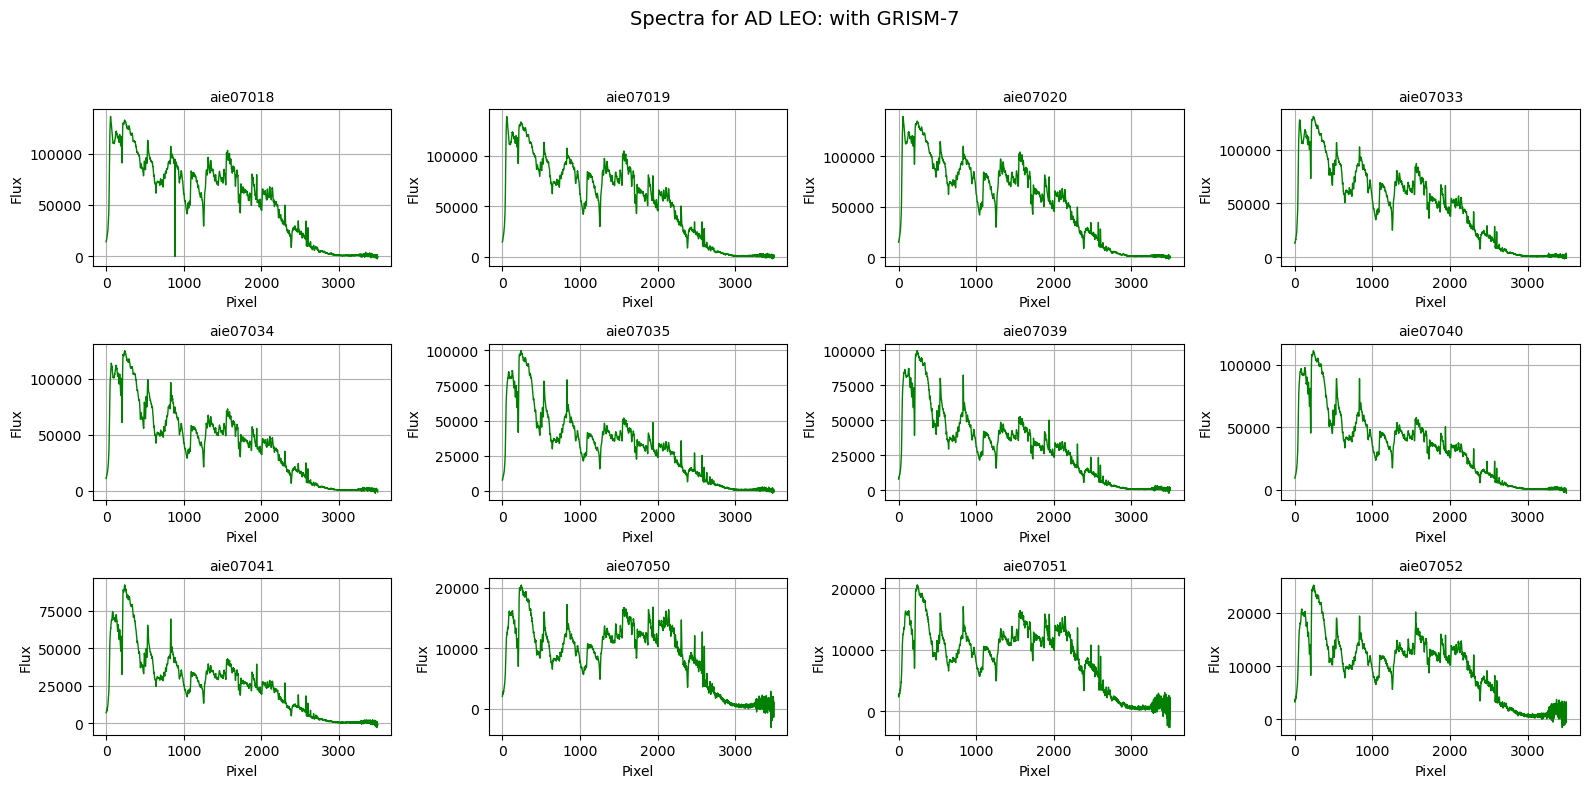

In [20]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os

# Only include IDs 18, 19, 20
valid_ids = [18, 19, 20, 33,34,35, 39,40,41,50,51,52]

input_folder = "/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/"

# Create subplots: 3 rows × 4 columns
fig, axs = plt.subplots(3, 4, figsize=(16, 8))
axs = axs.flatten()  # To index easily in 1D

for idx, i in enumerate(valid_ids):
    filename = f"spec_aie070{i:02d}.fits"
    filepath = os.path.join(input_folder, filename)

    try:
        data = fits.getdata(filepath)
        spectrum = data[0, 0, :] if data.ndim == 3 else data

        axs[idx].plot(spectrum, color='green', linewidth=1)
        axs[idx].set_title(f"aie070{i:02d}", fontsize=10)
        axs[idx].set_xlabel("Pixel")
        axs[idx].set_ylabel("Flux")
        axs[idx].grid(True)

    except Exception as e:
        axs[idx].text(0.5, 0.5, 'Error', ha='center')
        print(f"Error in {filename}: {e}")

# Adjust layout
plt.suptitle("Spectra for AD LEO: with GRISM-7", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])
#plt.savefig("/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC/spectrumpng/adleo_18_19_20.png", dpi=300, bbox_inches='tight')
plt.show()


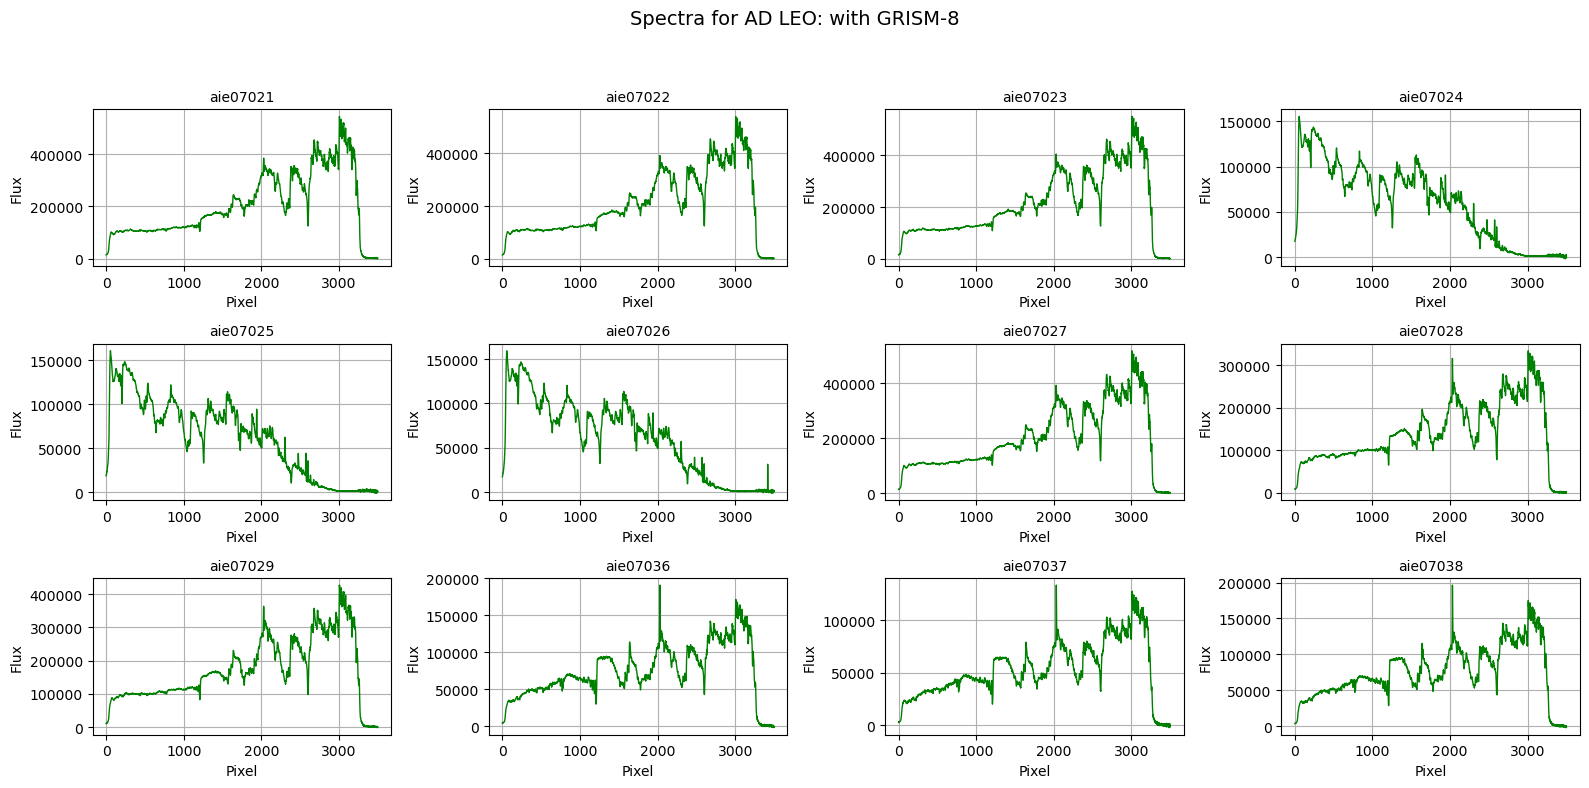

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os

# Only include IDs 18, 19, 20
valid_ids = [21,22,23,24,25,26,27,28,29,36,37,38]

input_folder = "/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/"

# Create subplots: 3 rows × 4 columns
fig, axs = plt.subplots(3, 4, figsize=(16, 8))
axs = axs.flatten()  # To index easily in 1D

for idx, i in enumerate(valid_ids):
    filename = f"spec_aie070{i:02d}.fits"
    filepath = os.path.join(input_folder, filename)

    try:
        data = fits.getdata(filepath)
        spectrum = data[0, 0, :] if data.ndim == 3 else data

        axs[idx].plot(spectrum, color='green', linewidth=1)
        axs[idx].set_title(f"aie070{i:02d}", fontsize=10)
        axs[idx].set_xlabel("Pixel")
        axs[idx].set_ylabel("Flux")
        axs[idx].grid(True)

    except Exception as e:
        axs[idx].text(0.5, 0.5, 'Error', ha='center')
        print(f"Error in {filename}: {e}")

# Adjust layout
plt.suptitle("Spectra for AD LEO: with GRISM-8", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.94])
#plt.savefig("/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC/spectrumpng/adleo_18_19_20.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib widget
# Load the FITS file
file_path = "/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/spec_aie07021.fits"
file=fits.open(file_path)[0].data 

# Plot the spectrum
plt.figure(figsize=(10, 4))
plt.plot(file, color='green', linewidth=1)
plt.title("Extracted Spectrum from aie07021(AD Leo)")
plt.xlabel("Pixel (Dispersion)")
plt.ylabel("Flux")
plt.grid(True)
plt.tight_layout()
plt.show()



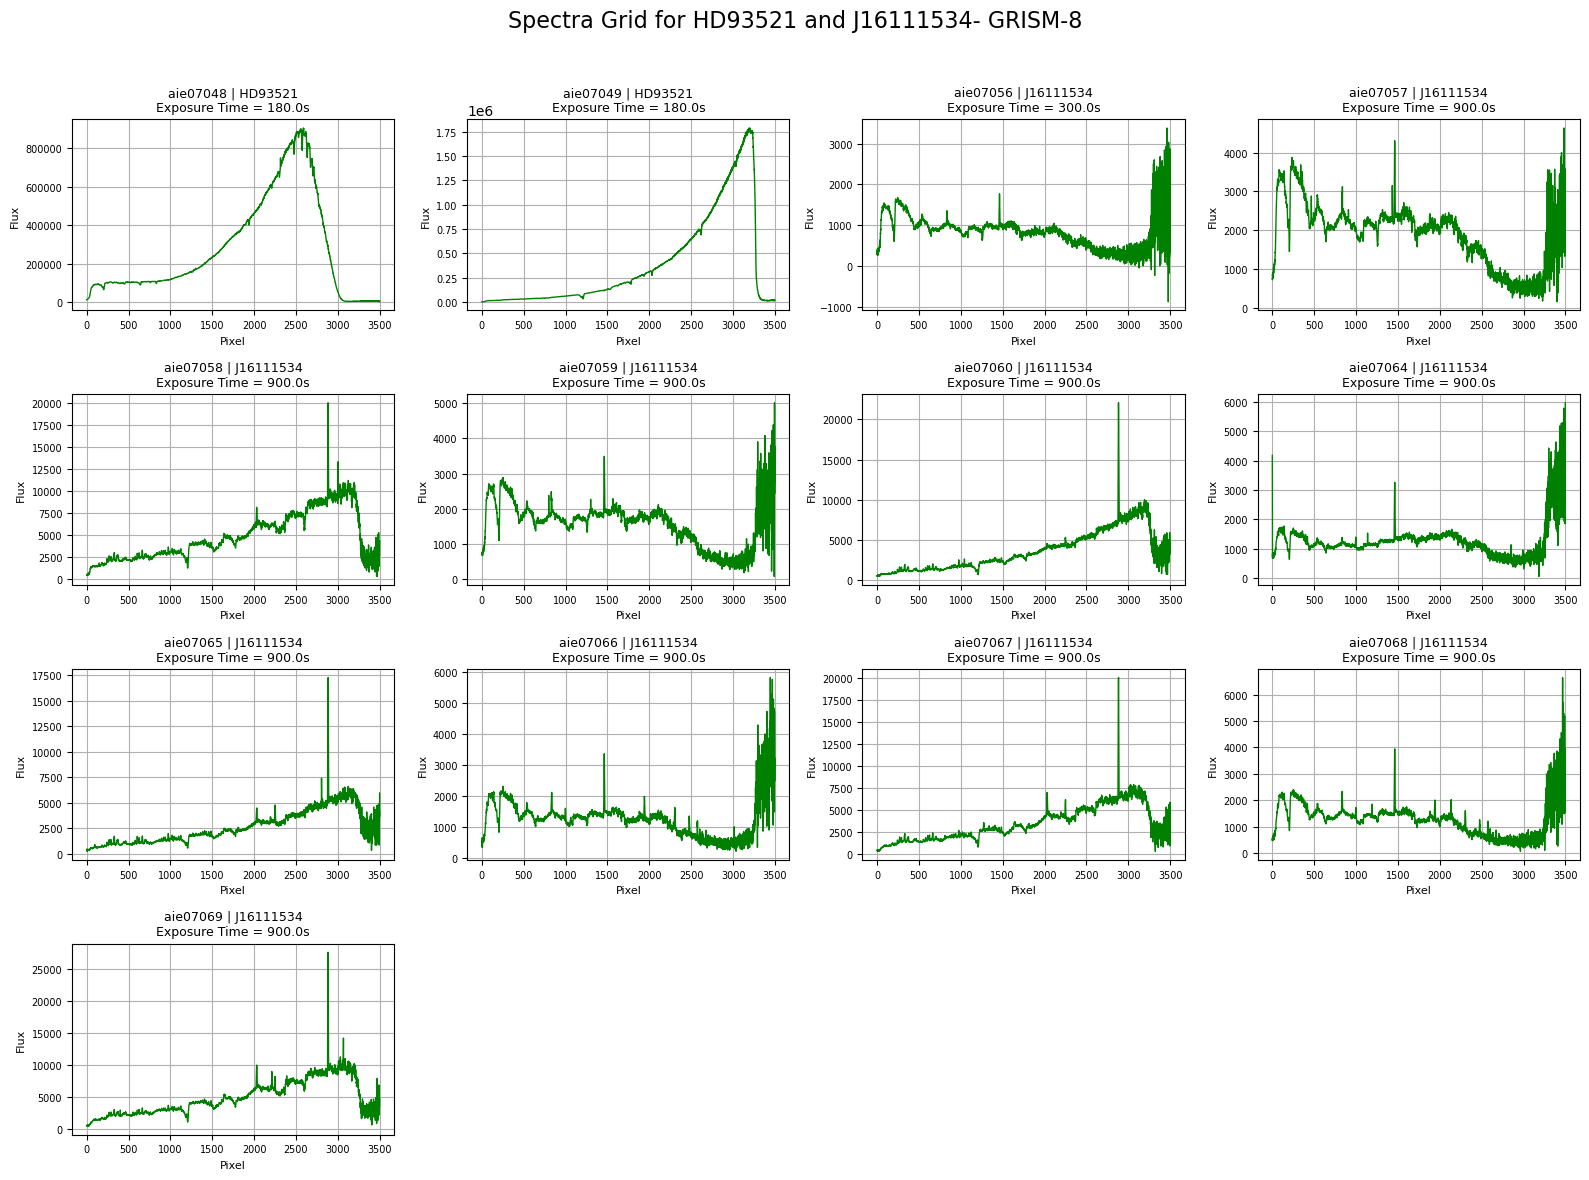

In [24]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os

# Selected IDs to plot
selected_ids = [48, 49, 56, 57, 58, 59, 60, 64, 65, 66, 67, 68, 69]

# Input folder
input_folder = "/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/"

# Calculate grid size
total = len(selected_ids)
cols = 4
rows = (total + cols - 1) // cols  # Ceiling division

# Prepare figure
fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axs = axs.flatten()

for idx, i in enumerate(selected_ids):
    filename = f"spec_aie070{i:02d}.fits"
    filepath = os.path.join(input_folder, filename)

    try:
        with fits.open(filepath) as hdul:
            data = hdul[0].data
            header = hdul[0].header
            exptime = header.get("EXPTIME", "N/A")

        # If 3D, take first slice
        spectrum = data[0, 0, :] if data.ndim == 3 else data

        # Assign object name manually
        object_name = "HD93521" if i in [48, 49] else "J16111534"

        axs[idx].plot(spectrum, color='green', linewidth=1)
        axs[idx].set_title(
            f"aie070{i:02d} | {object_name}\nExposure Time = {exptime}s",
            fontsize=9
        )
        axs[idx].set_xlabel("Pixel", fontsize=8)
        axs[idx].set_ylabel("Flux", fontsize=8)
        axs[idx].tick_params(axis='both', which='major', labelsize=7)
        axs[idx].grid(True)

    except Exception as e:
        axs[idx].text(0.5, 0.5, 'Error', ha='center')
        axs[idx].set_title(f"aie070{i:02d} | Error", fontsize=10)
        axs[idx].axis('off')
        print(f"Error in {filename}: {e}")

# Hide any unused subplots
for j in range(len(selected_ids), len(axs)):
    axs[j].axis('off')

# Save and show
plt.suptitle("Spectra Grid for HD93521 and J16111534- GRISM-8", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
#output_path = "/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC/Spectrumpng/spectra_Grid_for_HD93521_and_J16111534.png"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


In [3]:
from astropy.io import fits
file='/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/spec_aie07018.fits'
a=fits.open(file)[0].data[::-1]
print(a)

[ -277.65497 -1257.7495    238.5024  ... 15373.902   15033.105
 14339.783  ]


In [4]:
from astropy.io import fits
file=file='/home/abhayprusty/Documents/for_wavecal/AD leo/AD leo Grism 7/spec_18.fits'
'/home/abhayprusty/Documents/projects/Exoplanets/Datafiles/2025-05-07PC2/cosmic_cleaned/bias_subtracted/flat_fielded/spec_aie07018.fits'
a=fits.open(file)[0].data[::-1]
print(a)

[[[  43.537872   45.83168    45.682735 ...   17.157429   16.487932
     15.854318]]

 [[2370.0437   2522.2693   2574.7327   ... -591.7325   -282.0759
   -378.23807 ]]

 [[ 429.80365   417.89438   347.96112  ...  192.10162    41.145424
     53.152264]]

 [[ 305.44244   376.03998   309.3971   ...  170.17537   -42.60736
   -155.23839 ]]]
